In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50V2, EfficientNetB1
from keras import layers
from tensorflow import data as tf_data
import os
import random
import zipfile
import shutil
import pandas as pd

In [2]:
import reload_data2 as reload_data

## Baseline Attempt 2

In [ ]:
writer_images = list(range(27))

In [ ]:
train_set = writer_images[:15] #80/20 split --> 22/5
val_set = writer_images[15:21]
test_set = writer_images[21:]

In [ ]:
len(train_set),len(val_set),len(test_set)

(15, 6, 6)

In [ ]:
15/27,6/27

(0.5555555555555556, 0.2222222222222222)

In [3]:
IMAGE_SIZE = (442,442)
BATCH_SIZE = 64
INPUT_SHAPE = IMAGE_SIZE + (3,)
NUM_CLASSES = 90

In [ ]:
help(reload_data)

Help on module reload_data2:

NAME
    reload_data2

FUNCTIONS
    apply_augmentations()
        Apply `data_augmentation` to the training images.

    data_augmentation(images)
        Function for testing augmentations with test_augmentations(), not meant for use

        For applying augmentations, use: apply_augmentations()

    del_old_writer_directories(source_dir)
        Deletes original writer-organized directories (for use after creating train/val/test directories with stratify_split())

    full_unzip_and_stratify(path_of_zipfile, source_dir, IMAGE_SIZE=(384, 384), BATCH_SIZE=18)
        Starts with zipped file, divides unzipped images by author, splits sorted images into train/val/test images,
        creates & returns train/val/test datatsets

    organize_unzipped_files(source_dir)
        Organizes raw unzipped files into writer folders

    stratify_split(source_dir, split=[15, 6, 6])
        Re-organizes images in writer folders into train/val/test folders with writer 

In [ ]:
source_dir = "/content/Data"

In [ ]:
shutil.rmtree(source_dir)

In [ ]:
train_ds,val_ds,test_ds = reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip",source_dir,IMAGE_SIZE,BATCH_SIZE)

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


#### Copied from `Colab_ExtraModels_Train.ipynb`

In [ ]:
base_model = EfficientNetB1(include_top = False,
                        classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(IMAGE_SIZE + (3,))
                        )

In [ ]:
def make_transfer_model(input_shape, num_classes):
    backbone = base_model

    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.resnet.preprocess_input(inputs)
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)

    units = num_classes

    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(units, activation=None)(x)

    return keras.Model(inputs, outputs, name="baseline")


model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=90)

In [ ]:
#from tensorflow.keras.applications import efficientnet

def alt_make_transfer_model(input_shape, num_classes):
    backbone = base_model
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = efficientnet.preprocess_input(inputs)  # <-- match to the base model
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x)
    outputs = layers.Dense(num_classes, activation=None)(x)

    return keras.Model(inputs, outputs, name="baseline")


In [ ]:
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [ ]:
%%time

epochs = 70

callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

history = model.fit(
    train_ds,
    epochs= epochs,
    callbacks= callbacks,
    validation_data= val_ds)

model.save("/content/EfficientNet.keras")

Epoch 1/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - acc: 0.4535 - loss: 2.6658 - val_acc: 0.4852 - val_loss: 2.6960
Epoch 2/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - acc: 0.4706 - loss: 2.6490 - val_acc: 0.5093 - val_loss: 2.6681
Epoch 3/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 325ms/step - acc: 0.4742 - loss: 2.5830 - val_acc: 0.5167 - val_loss: 2.6412
Epoch 4/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - acc: 0.4936 - loss: 2.5228 - val_acc: 0.5148 - val_loss: 2.6184
Epoch 5/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step - acc: 0.5199 - loss: 2.5142 - val_acc: 0.5222 - val_loss: 2.5894
Epoch 6/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 320ms/step - acc: 0.5117 - loss: 2.4752 - val_acc: 0.5204 - val_loss: 2.5652
Epoch 7/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 317ms/step - acc: 0.4942 - loss: 2.5153 - val_acc: 0.5352 - val_loss: 2.5419
Epoch 8/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 324ms/step - acc: 0.5463 - loss: 2.4113 - val_acc: 0.5315 - val_loss: 2.5170
Epoch 9/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 7s 316ms/step - acc:

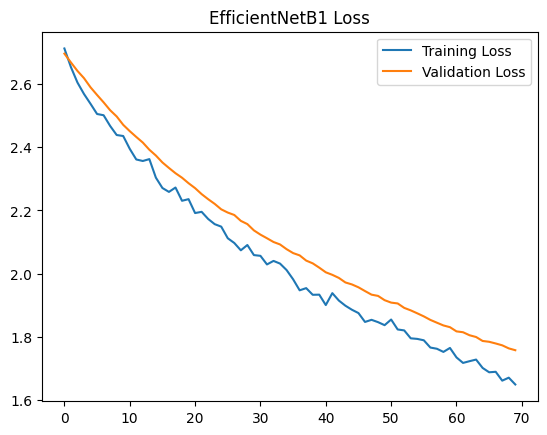

In [ ]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.title("EfficientNetB1 Loss")
plt.legend()
plt.show()

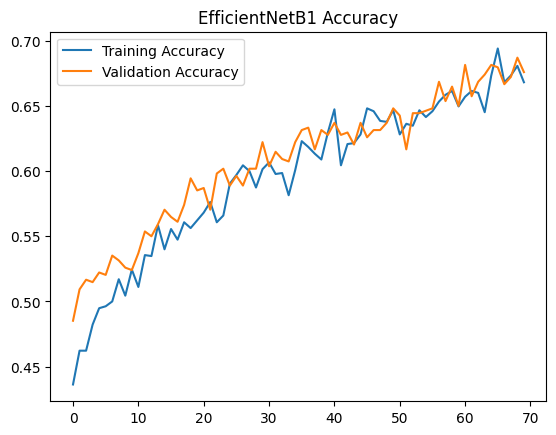

In [ ]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.title("EfficientNetB1 Accuracy")
plt.legend()
plt.show()

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - acc: 0.7112 - loss: 1.8505
Test accuracy: 0.717
Test loss: 1.799


In [ ]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step


In [ ]:
class_names = reload_data.w_ids
for i in range(5):
    print(f"Predicted: {class_names[predicted_classes[i]]}")

Predicted: w0069
Predicted: w0145
Predicted: w0006
Predicted: w0020
Predicted: w0133


2/2 ━━━━━━━━━━━━━━━━━━━━ 40s 68ms/step


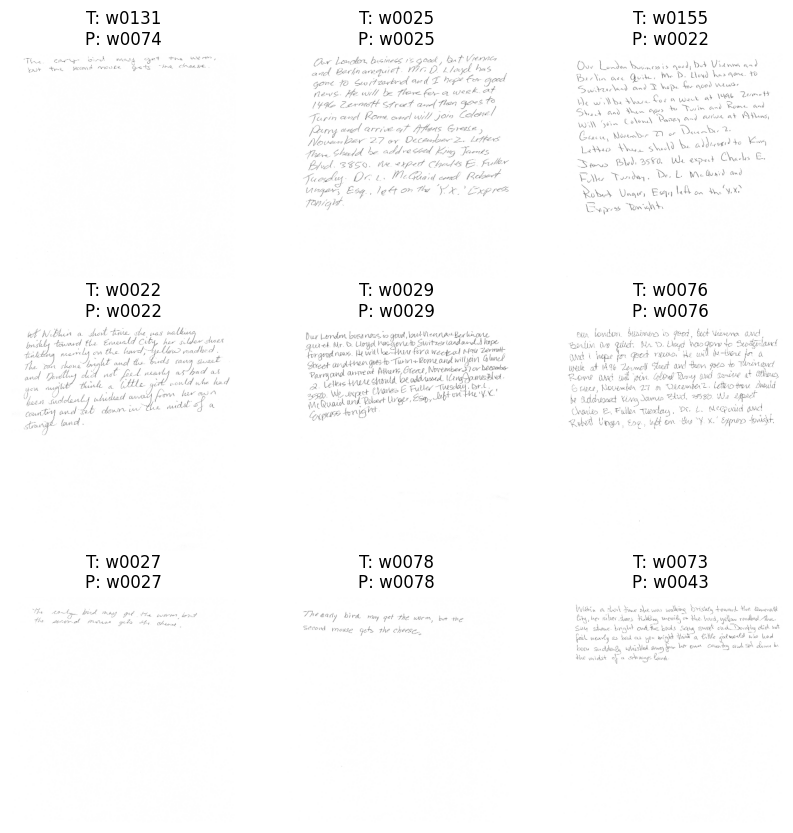

In [ ]:
for images, labels in test_ds.take(1):
    preds = model.predict(images)
    pred_labels = np.argmax(preds, axis=1)

    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        true_label = class_names[labels[i]]
        pred_label = class_names[pred_labels[i]]
        plt.title(f"T: {true_label}\nP: {pred_label}")
        plt.axis("off")
    plt.show()

### More Epochs

Trying to get plateau

In [1]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
from keras.applications import ResNet50V2, EfficientNetB1
from keras import layers
from tensorflow import data as tf_data
import os
import random
import zipfile
import shutil
import pandas as pd

In [2]:
import reload_data2 as reload_data

In [3]:
IMAGE_SIZE = (442,442)
BATCH_SIZE = 64
INPUT_SHAPE = IMAGE_SIZE + (3,)
NUM_CLASSES = 90

In [4]:
base_model = keras.applications.MobileNetV2(
                        include_top = False,
                        classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(IMAGE_SIZE + (3,))
                        )

/tmp/ipython-input-2678541025.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
source_dir = "/content/Data"

In [7]:
train_ds,val_ds,test_ds = reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip",source_dir,IMAGE_SIZE,BATCH_SIZE)

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


In [8]:
def make_transfer_model(input_shape, num_classes):
    backbone = base_model

    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs) #changed to mobilenetv2
    x = backbone(x)
    x = layers.Dropout(0.3)(x)

    x = layers.GlobalAveragePooling2D()(x)

    x = layers.Dropout(0.25)(x) #changed to 30% dropout
    outputs = layers.Dense(num_classes, activation=None)(x)

    return keras.Model(inputs, outputs, name="mobilenet_moreepochs")


model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=90)

In [9]:
train_ds = train_ds.prefetch(tf_data.AUTOTUNE)
val_ds = val_ds.prefetch(tf_data.AUTOTUNE)

In [10]:
%%time

epochs = 120

#callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )

history = model.fit(
    train_ds,
    epochs= epochs,
    #callbacks= callbacks,
    validation_data= val_ds)

model.save("MobileNetV2_120.keras")

Epoch 1/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 102s 3s/step - acc: 0.0154 - loss: 4.9470 - val_acc: 0.0370 - val_loss: 4.3559
Epoch 2/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - acc: 0.0289 - loss: 4.4769 - val_acc: 0.1074 - val_loss: 4.0850
Epoch 3/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - acc: 0.0804 - loss: 4.1259 - val_acc: 0.1630 - val_loss: 3.8964
Epoch 4/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 284ms/step - acc: 0.1055 - loss: 3.9401 - val_acc: 0.2444 - val_loss: 3.7251
Epoch 5/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - acc: 0.1541 - loss: 3.7126 - val_acc: 0.2926 - val_loss: 3.5749
Epoch 6/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - acc: 0.1867 - loss: 3.5674 - val_acc: 0.3259 - val_loss: 3.4407
Epoch 7/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 275ms/step - acc: 0.2381 - loss: 3.3984 - val_acc: 0.3407 - val_loss: 3.3171
Epoch 8/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 283ms/step - acc: 0.2388 - loss: 3.3319 - val_acc: 0.3722 - val_loss: 3.2089
Epoch 9/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 276ms/s

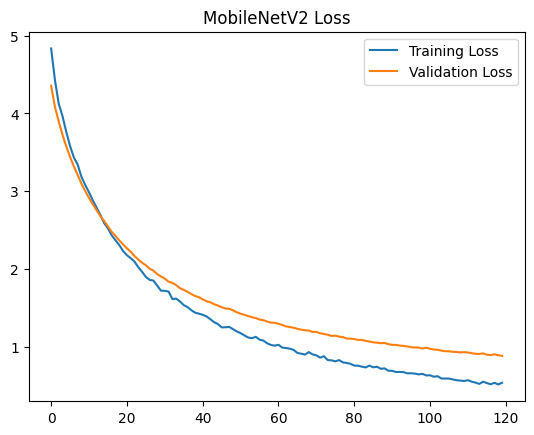

In [11]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.title("MobileNetV2 Loss")
plt.legend()
plt.show()

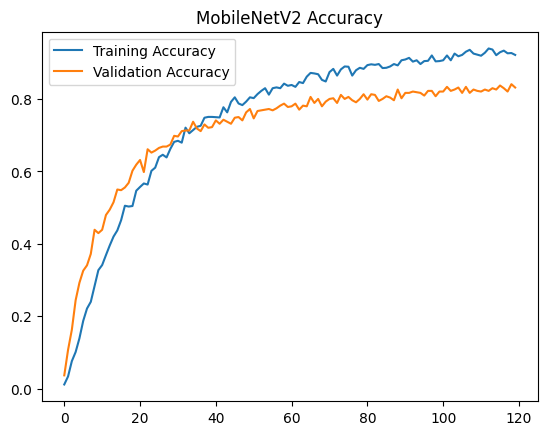

In [12]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.legend()
plt.show()

In [13]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 183ms/step - acc: 0.7850 - loss: 1.0048
Test accuracy: 0.791
Test loss: 0.967


In [14]:
predictions = model.predict(test_ds)
predicted_classes = np.argmax(predictions, axis=1)

9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 887ms/step


*Change resolution to 224x224*

# Metadata Target Var. Attempt

**Examples:**
* age group
* gender
* handedness

First need to figure out how to modify python script to change directory structure based on metadata in csv

In [ ]:
df = pd.read_csv("/content/CSAFE_Handwriting_Info.csv")
df.head(10)

,wid,agegroup,gender,hand,thirdgrade_usa,thirdgrade_usa_region,s1_dae,s1_time,s2_dae,s2_time,s3_dae,s3_time,db_version
0,180,61+,Female,Right,True,Midwest,0.0,Late Morning,28.0,Late Morning,66.0,Late Morning,version5
1,410,18-24,Female,Right,True,Midwest,0.0,Late Afternoon,32.0,Late Evening,54.0,Early Evening,version5
2,593,18-24,Male,Left,True,Midwest,0.0,Late evening (later than 7:30pm),30.0,Late evening (later than 7:30pm),61.0,Early evening (5pm-7:30pm),version5
3,520,18-24,Female,Right,True,Midwest,0.0,Late Evening,26.0,Late Morning,54.0,Late Morning,version5
4,233,18-24,Male,Right,False,NaN,340.0,Late Evening,380.0,Late Evening,0.0,Late Evening,version5
5,35,41-60,female,right,False,NaN,0.0,lateevening,24.0,latemorning,64.0,earlyevening,version5
6,661,18-24,Female,Right,True,Midwest,0.0,Late Afternoon,41.0,Late Afternoon,57.0,Late Evening,version5
7,420,18-24,Female,Right,True,NaN,0.0,Late Afternoon,52.0,Early Afternoon,73.0,Late Afternoon,version5
8,62,41-60,female,right,True,midwest,0.0,lateevening,54.0,latemorning,98.0,earlyevening,version5
9,572,18-24,Female,Right,True,Midwest,0.0,Late morning (9:30am-12:00pm),24.0,Late morning (9:30am-12:00pm),54.0,Early afternoon (12:00pm-2:30pm),version5


In [ ]:
df.shape

(466, 13)

In [ ]:
important_cols = ["wid","agegroup","gender","hand"]

In [ ]:
for col in df.columns[1:-1]:
    print(f"{col}: {len(df[col].unique())}")
    print(df[col].unique(),"\n\n")

agegroup: 5
['61+' '18-24' '41-60' '25-40' nan] 


gender: 6
['Female' 'Male' 'female' 'male' nan 'Other'] 


hand: 7
['Right' 'Left' 'right' 'Ambidextrous' nan 'left' 'ambidextrous'] 


thirdgrade_usa: 3
[True False nan] 


thirdgrade_usa_region: 9
['Midwest' nan 'midwest' 'South' 'Northeast' 'south' 'West' 'northeast'
 'west'] 


s1_dae: 6
[  0. 340.  nan  33. 362. 401.] 


s1_time: 19
['Late Morning' 'Late Afternoon' 'Late evening (later than 7:30pm)'
 'Late Evening' 'lateevening' 'Late morning (9:30am-12:00pm)'
 'Late afternoon (2:30pm-5pm)' 'Early afternoon (12:00pm-2:30pm)'
 'Early Afternoon' nan 'Early Evening' 'Early evening (5pm-7:30pm)'
 'earlyafternoon' 'lateafternoon' 'Early morning (earlier than 9:30am)'
 'earlyevening' 'Early Morning' 'latemorning' 'earlymorning'] 


s2_dae: 91
[ 28.  32.  30.  26. 380.  24.  41.  52.  54.  22.  27.  42.  97.  33.
  44.  23.  61.  21.  nan  34.  70.  45.  53.  55. 168.  20.  29.  47.
  37.  40.   0.  35.  25.  49.  59.  48.  31.  76. 123.

In [ ]:
df[important_cols].isnull().sum()

,0
wid,0
agegroup,3
gender,3
hand,1


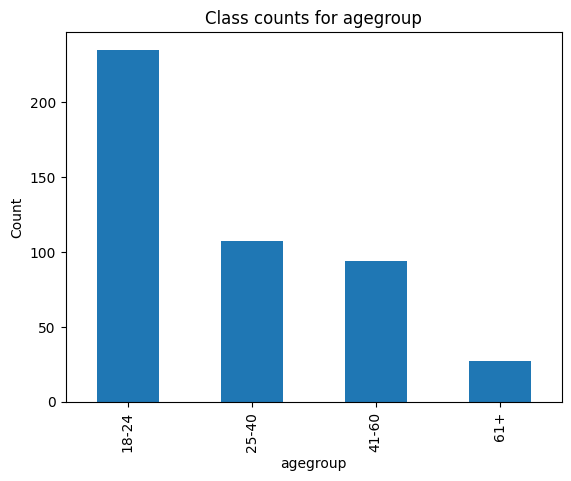

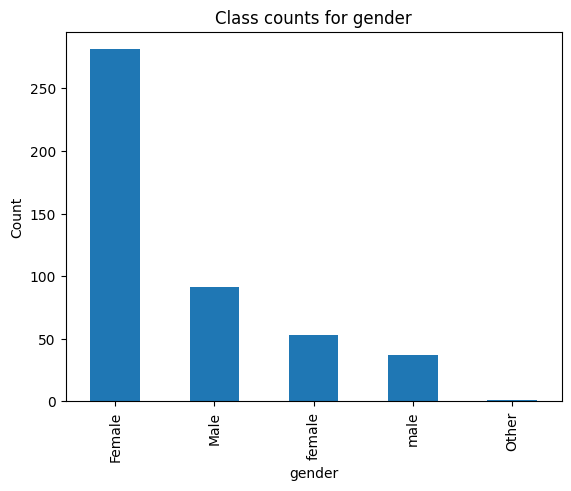

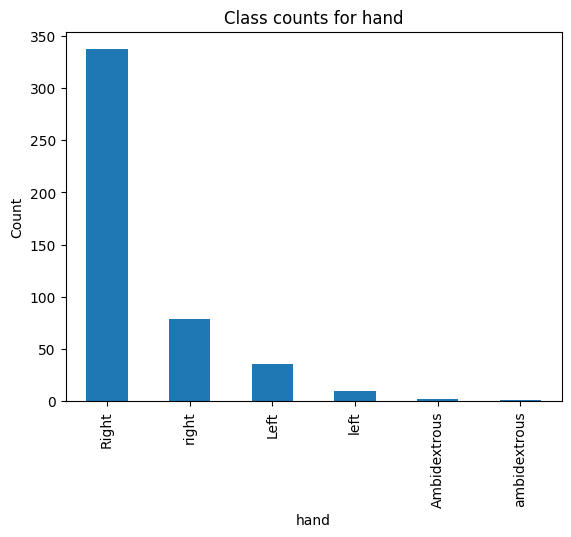

In [ ]:
for col in important_cols[1:]:
    df[col].value_counts().plot(kind='bar')
    plt.title(f'Class counts for {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [ ]:
help(reload_data)

Help on module reload_data2:

NAME
    reload_data2

FUNCTIONS
    apply_augmentations()
        Apply `data_augmentation` to the training images.

    data_augmentation(images)
        Function for testing augmentations with test_augmentations(), not meant for use

        For applying augmentations, use: apply_augmentations()

    del_old_writer_directories(source_dir)
        Deletes original writer-organized directories (for use after creating train/val/test directories with stratify_split())

    full_unzip_and_stratify(path_of_zipfile, source_dir, IMAGE_SIZE=(384, 384), BATCH_SIZE=18)
        Starts with zipped file, divides unzipped images by author, splits sorted images into train/val/test images,
        creates & returns train/val/test datatsets

    organize_unzipped_files(source_dir)
        Organizes raw unzipped files into writer folders

    stratify_split(source_dir, split=[15, 6, 6])
        Re-organizes images in writer folders into train/val/test folders with writer 

In [ ]:
zip_path = "/content/CSAFE_Handwriting_Images.zip"
source_dir = "/content/Data"

In [ ]:
try:
    shutil.rmtree("/content/Data")
except:
    pass
train_sd,val_ds,test_ds = reload_data.full_unzip_and_stratify(
    zip_path, source_dir)

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


In [ ]:
os.listdir("/content/Data/train")

['w0093',
 'w0153',
 'w0063',
 'w0136',
 'w0026',
 'w0086',
 'w0018',
 'w0020',
 'w0023',
 'w0149',
 'w0082',
 'w0152',
 'w0075',
 'w0089',
 'w0078',
 'w0130',
 'w0083',
 'w0005',
 'w0134',
 'w0088',
 'w0145',
 'w0142',
 'w0154',
 'w0001',
 'w0073',
 'w0038',
 'w0129',
 'w0012',
 'w0010',
 'w0151',
 'w0139',
 'w0064',
 'w0125',
 'w0092',
 'w0017',
 'w0061',
 'w0148',
 'w0016',
 'w0013',
 'w0066',
 'w0031',
 'w0022',
 'w0027',
 'w0043',
 'w0122',
 'w0091',
 'w0121',
 'w0156',
 'w0080',
 'w0128',
 'w0085',
 'w0004',
 'w0087',
 'w0077',
 'w0144',
 'w0015',
 'w0032',
 'w0135',
 'w0033',
 'w0024',
 'w0143',
 'w0025',
 'w0011',
 'w0003',
 'w0006',
 'w0009',
 'w0137',
 'w0155',
 'w0071',
 'w0123',
 'w0074',
 'w0131',
 'w0002',
 'w0076',
 'w0095',
 'w0034',
 'w0030',
 'w0029',
 'w0062',
 'w0124',
 'w0028',
 'w0138',
 'w0036',
 'w0126',
 'w0035',
 'w0133',
 'w0147',
 'w0070',
 'w0069',
 'w0094']

In [ ]:
def standard_wids(x):
    if x >= 100:
        return f"w0{x}"
    elif x>=10:
        return f"w00{x}"
    elif x<10:
        return f"w000{x}"

df["wid_string"] = df["wid"].apply(lambda x: standard_wids(x))
df.head(10)

,wid,agegroup,gender,hand,thirdgrade_usa,thirdgrade_usa_region,s1_dae,s1_time,s2_dae,s2_time,s3_dae,s3_time,db_version,wid_string
0,180,61+,Female,Right,True,Midwest,0.0,Late Morning,28.0,Late Morning,66.0,Late Morning,version5,w0180
1,410,18-24,Female,Right,True,Midwest,0.0,Late Afternoon,32.0,Late Evening,54.0,Early Evening,version5,w0410
2,593,18-24,Male,Left,True,Midwest,0.0,Late evening (later than 7:30pm),30.0,Late evening (later than 7:30pm),61.0,Early evening (5pm-7:30pm),version5,w0593
3,520,18-24,Female,Right,True,Midwest,0.0,Late Evening,26.0,Late Morning,54.0,Late Morning,version5,w0520
4,233,18-24,Male,Right,False,NaN,340.0,Late Evening,380.0,Late Evening,0.0,Late Evening,version5,w0233
5,35,41-60,female,right,False,NaN,0.0,lateevening,24.0,latemorning,64.0,earlyevening,version5,w0035
6,661,18-24,Female,Right,True,Midwest,0.0,Late Afternoon,41.0,Late Afternoon,57.0,Late Evening,version5,w0661
7,420,18-24,Female,Right,True,NaN,0.0,Late Afternoon,52.0,Early Afternoon,73.0,Late Afternoon,version5,w0420
8,62,41-60,female,right,True,midwest,0.0,lateevening,54.0,latemorning,98.0,earlyevening,version5,w0062
9,572,18-24,Female,Right,True,Midwest,0.0,Late morning (9:30am-12:00pm),24.0,Late morning (9:30am-12:00pm),54.0,Early afternoon (12:00pm-2:30pm),version5,w0572


In [ ]:
common = list(set(df["wid_string"]) & set(reload_data.w_ids))
len(common)

In [ ]:
writer_gender_90 = list() #list of tuples with version 1 writers + gender

for wid in reload_data.w_ids:
    ind = df["wid_string"].loc[ df["wid_string"] == wid ]
    ind = int(str(ind)[:3]) #index of writer id

    writer_gender_90.append( (wid,df['gender'].iloc[ind].strip().lower() ))

In [ ]:
writer_hand_90 = list() #list of tuples with version 1 writers + handedness

for wid in reload_data.w_ids:
    ind = df["wid_string"].loc[ df["wid_string"] == wid ]
    ind = int(str(ind)[:3]) #index of writer id

    writer_hand_90.append( (wid,df['hand'].iloc[ind].strip().lower() ))

In [ ]:
writer_age_90 = list() #list of tuples with version 1 writers + age

for wid in reload_data.w_ids:
    ind = df["wid_string"].loc[ df["wid_string"] == wid ]
    ind = int(str(ind)[:3]) #index of writer id

    writer_age_90.append( (wid,df['agegroup'].iloc[ind].strip().lower() ))

### Converting directory structure

#### Gender

In [ ]:
writer_gender_90 = dict(writer_gender_90)
print(writer_gender_90)

{'w0001': 'female', 'w0002': 'male', 'w0003': 'female', 'w0004': 'female', 'w0005': 'male', 'w0006': 'male', 'w0009': 'female', 'w0010': 'female', 'w0011': 'male', 'w0012': 'male', 'w0013': 'female', 'w0015': 'female', 'w0016': 'female', 'w0017': 'male', 'w0018': 'female', 'w0020': 'female', 'w0022': 'female', 'w0023': 'female', 'w0024': 'female', 'w0025': 'male', 'w0026': 'male', 'w0027': 'female', 'w0028': 'female', 'w0029': 'female', 'w0030': 'male', 'w0031': 'male', 'w0032': 'male', 'w0033': 'female', 'w0034': 'female', 'w0035': 'female', 'w0036': 'female', 'w0038': 'female', 'w0043': 'male', 'w0061': 'female', 'w0062': 'female', 'w0063': 'female', 'w0064': 'female', 'w0066': 'male', 'w0069': 'female', 'w0070': 'male', 'w0071': 'male', 'w0073': 'male', 'w0074': 'male', 'w0075': 'female', 'w0076': 'female', 'w0077': 'male', 'w0078': 'male', 'w0080': 'female', 'w0082': 'male', 'w0083': 'female', 'w0085': 'male', 'w0086': 'female', 'w0087': 'female', 'w0088': 'male', 'w0089': 'male', 

In [ ]:
#create class folders
os.mkdir("/content/Data/test/male")
male_dir = "/content/Data/test/male"
os.mkdir("/content/Data/test/female")
female_dir = "/content/Data/test/female"

current_dir="/content/Data/test"
for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
    if w_folder in ["male", "female"]:  # skip your new folders
        continue
    cat = writer_gender_90[w_folder]
    if cat == "male":
        # Move the entire folder 'source_folder' into 'destination_folder'
        shutil.move(f"{current_dir}/{w_folder}", male_dir)
    elif cat == "female":
        shutil.move(f"{current_dir}/{w_folder}", female_dir)
    else:
        print(f"SKIPPED: {w_id} --> {cat}")

Repeat above for `val` & `train`

In [ ]:
for current_dir in ["/content/Data/val","/content/Data/train"]:
    os.mkdir(f"{current_dir}/male")
    male_dir = f"{current_dir}/male"
    os.mkdir(f"{current_dir}/female")
    female_dir = f"{current_dir}/female"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in ["male", "female"]:  # skip your new folders
            continue
        cat = writer_gender_90[w_folder]
        if cat == "male":
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", male_dir)
        elif cat == "female":
            shutil.move(f"{current_dir}/{w_folder}", female_dir)
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

## Gender Target Variable Attempt

In [27]:
gender_df = pd.read_csv("/content/gender_df.csv")
gender_df.head()

,Unnamed: 0,wid,agegroup,gender,hand
0,0,180,61+,Female,Right
1,1,410,18-24,Female,Right
2,2,593,18-24,Male,Left
3,3,520,18-24,Female,Right
4,4,233,18-24,Male,Right


In [28]:
gender_df.isnull().sum()

,0
Unnamed: 0,0
wid,0
agegroup,2
gender,0
hand,0


In [29]:
gender_df.shape

(463, 5)

Get proper 90-class subset

In [30]:
gender_df = gender_df[gender_df["wid"].isin([int(x[2:]) for x in reload_data.w_ids])].reset_index(drop=True)
gender_df.shape

(90, 5)

In [32]:
cat = gender_df.loc[gender_df["wid"] == 1, "gender"].iloc[0]
cat

'female'

In [42]:
#shutil.rmtree("/content/Data")
reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data")

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [43]:
for current_dir in ["/content/Data/val","/content/Data/train","/content/Data/test"]:
    os.mkdir(f"{current_dir}/male")
    male_dir = f"{current_dir}/male"
    os.mkdir(f"{current_dir}/female")
    female_dir = f"{current_dir}/female"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in ["male", "female"]:  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = gender_df.loc[gender_df["wid"] == id, "gender"].iloc[0]

        if cat == "male":
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", male_dir)
        elif cat == "female":
            shutil.move(f"{current_dir}/{w_folder}", female_dir)
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

Gender-based directories created

--> making tensorflow objects now

In [36]:
help(reload_data.train_val_test_split)

Help on function train_val_test_split in module reload_data2:

train_val_test_split(source_dir, IMAGE_SIZE=(384, 384), BATCH_SIZE=18)



In [44]:
source_dir

'/content/Data'

In [46]:
IMAGE_SIZE=(256,256)
print(BATCH_SIZE)

64


In [47]:
gen_train_ds,gen_val_ds,gen_test_ds = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE
)

Found 1350 files belonging to 2 classes.
Found 540 files belonging to 2 classes.
Found 540 files belonging to 2 classes.


In [49]:
gender_df["gender"].value_counts()

,count
gender,
female,53
male,37


^^ slight class imbalance

In [65]:
53/90

0.5888888888888889

In [55]:
base_model = keras.applications.MobileNetV2(
                        include_top = False,
                        classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(IMAGE_SIZE + (3,))
                        )

/tmp/ipython-input-2678541025.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = keras.applications.MobileNetV2(


In [56]:
def make_transfer_model(input_shape, num_classes):
    backbone = base_model
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs) #changed to mobilenetv2
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x) #changed to 30% dropout

    outputs = layers.Dense(1, activation=None)(x) #change to binary (1 neuron)

    return keras.Model(inputs, outputs, name="mobilenet_gender")

INPUT_SHAPE = (256,256,3)
model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=2)

In [57]:
gen_train_ds = gen_train_ds.prefetch(tf_data.AUTOTUNE)
gen_val_ds = gen_val_ds.prefetch(tf_data.AUTOTUNE)

In [58]:
%%time

epochs = 70

#callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )

history = model.fit(
    gen_train_ds,
    epochs= epochs,
    #callbacks= callbacks,
    validation_data= gen_val_ds)

model.save("MobileNetV2_gender.keras")

Epoch 1/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 71s 2s/step - acc: 0.5849 - loss: 0.7271 - val_acc: 0.5889 - val_loss: 0.6628
Epoch 2/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - acc: 0.5982 - loss: 0.6966 - val_acc: 0.6000 - val_loss: 0.6495
Epoch 3/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - acc: 0.6019 - loss: 0.6734 - val_acc: 0.6000 - val_loss: 0.6371
Epoch 4/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 264ms/step - acc: 0.5943 - loss: 0.6630 - val_acc: 0.6093 - val_loss: 0.6297
Epoch 5/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 263ms/step - acc: 0.6355 - loss: 0.6345 - val_acc: 0.6056 - val_loss: 0.6236
Epoch 6/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 260ms/step - acc: 0.6165 - loss: 0.6399 - val_acc: 0.6056 - val_loss: 0.6175
Epoch 7/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 265ms/step - acc: 0.6288 - loss: 0.6251 - val_acc: 0.6352 - val_loss: 0.6247
Epoch 8/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 259ms/step - acc: 0.6210 - loss: 0.6223 - val_acc: 0.6056 - val_loss: 0.6166
Epoch 9/70
22/22 ━━━━━━━━━━━━━━━━━━━━ 6s 268ms/step - acc:

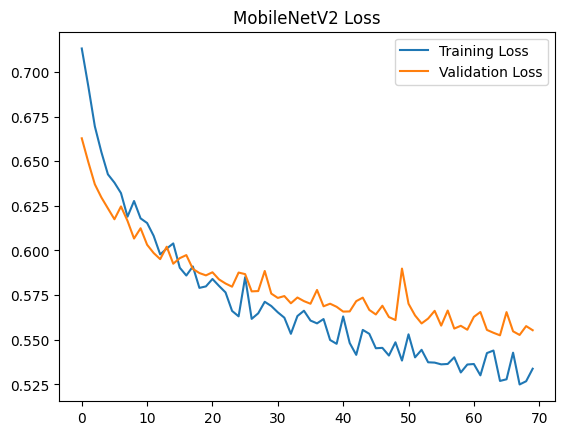

In [59]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.title("MobileNetV2 Loss")
plt.legend()
plt.show()

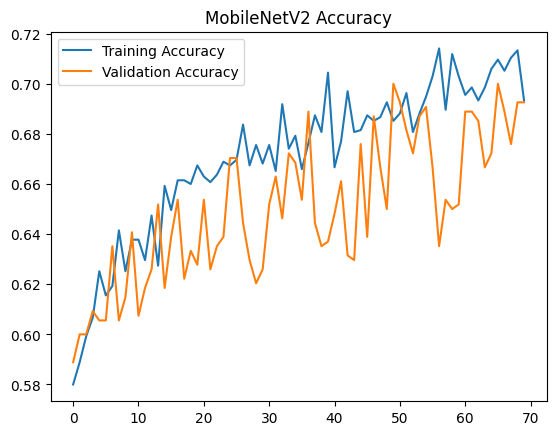

In [60]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.title("MobileNetV2 Accuracy")
plt.legend()
plt.show()

Try to control for jaggedness:
* lower learning rate of Adam
* decrease batch size

In [61]:
test_loss, test_acc = model.evaluate(gen_test_ds)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - acc: 0.7120 - loss: 0.5052
Test accuracy: 0.722
Test loss: 0.508


In [62]:
gender_lossacc = pd.DataFrame(history.history)
gender_lossacc.head()

,acc,loss,val_acc,val_loss
0,0.580000,0.713107,0.588889,0.662819
1,0.588889,0.691998,0.600000,0.649512
2,0.599259,0.669506,0.600000,0.637060
3,0.606667,0.655113,0.609259,0.629717
4,0.625185,0.642645,0.605556,0.623588


In [63]:
#gender_lossacc.to_csv("gender_lossacc.csv")

## Age Target Var. Attempt

In [68]:
age_df = gender_df[["wid","agegroup"]].copy()
age_df.isnull().sum()

,0
wid,0
agegroup,0


In [69]:
age_df["agegroup"].value_counts()

,count
agegroup,
41-60,29
18-24,27
25-40,25
61+,9


Will deal with imbalance using class weights

In [72]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(age_df["agegroup"]),
    y=age_df["agegroup"]
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.8333333333333334), 1: np.float64(0.9), 2: np.float64(0.7758620689655172), 3: np.float64(2.5)}


In [73]:
shutil.rmtree("/content/Data")
reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data")

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [77]:
"41-60" in age_df["agegroup"].unique()

True

In [78]:
for current_dir in ["/content/Data/val","/content/Data/train","/content/Data/test"]:
    for group in age_df["agegroup"].unique():
        os.mkdir(f"{current_dir}/{group}")
        #dir = f"{current_dir}/{group}"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in age_df["agegroup"].unique():  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = age_df.loc[age_df["wid"] == id, "agegroup"].iloc[0]

        if cat in age_df["agegroup"].unique():
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", f"{current_dir}/{cat}")
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

In [79]:
source_dir

'/content/Data'

In [80]:
IMAGE_SIZE=(256,256)
BATCH_SIZE = 32

In [81]:
#Did not work with class weights
age_train_ds,age_val_ds,age_test_ds = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE
)

Found 1350 files belonging to 4 classes.
Found 540 files belonging to 4 classes.
Found 540 files belonging to 4 classes.


In [92]:
#Re-doing datasets to ensure proper size
IMAGE_SIZE = (256,256)
BATCH_SIZE = 32

age_train_ds = tf.keras.utils.image_dataset_from_directory(
    f"{source_dir}/train",
    label_mode='int',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    )
age_val_ds = tf.keras.utils.image_dataset_from_directory(
    f"{source_dir}/val",
    label_mode='int',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    )
age_test_ds = tf.keras.utils.image_dataset_from_directory(
    f"{source_dir}/test",
    label_mode='int',
    color_mode='rgb',
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    )

Found 1350 files belonging to 4 classes.
Found 540 files belonging to 4 classes.
Found 540 files belonging to 4 classes.


In [99]:
age_model = keras.applications.MobileNetV2(
                        include_top = False,
                        classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(256,256,3)
                        )

/tmp/ipython-input-677114163.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  age_model = keras.applications.MobileNetV2(


In [100]:
def make_transfer_model(input_shape, num_classes):
    backbone = age_model
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs) #changed to mobilenetv2
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x) #changed to 30% dropout

    outputs = layers.Dense(num_classes, activation=None)(x) #change to 4 neurons

    return keras.Model(inputs, outputs, name="mobilenet_age")

INPUT_SHAPE = (256,256,3)
model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=4)

In [101]:
age_train_ds = age_train_ds.prefetch(tf_data.AUTOTUNE)
age_val_ds = age_val_ds.prefetch(tf_data.AUTOTUNE)

In [103]:
for images, labels in age_train_ds.take(1):
    print(images.shape)  # (batch_size, 256, 256, 3)
    print(labels.shape)  # (batch_size,) <- integer labels!
    print(labels[:10])


(32, 256, 256, 3)
(32,)
tf.Tensor([2 2 2 0 3 2 2 2 1 2], shape=(10,), dtype=int32)


In [104]:
%%time

epochs = 70

#callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")]
    )

history = model.fit(
    age_train_ds,
    epochs= epochs,
    class_weight=class_weights,
    validation_data= age_val_ds
    )

model.save("MobileNetV2_age.keras")

Epoch 1/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 45s 454ms/step - acc: 0.2599 - loss: 1.5725 - val_acc: 0.4407 - val_loss: 1.2613
Epoch 2/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 0.3500 - loss: 1.3643 - val_acc: 0.4611 - val_loss: 1.2385
Epoch 3/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - acc: 0.4555 - loss: 1.2348 - val_acc: 0.4222 - val_loss: 1.2730
Epoch 4/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step - acc: 0.4557 - loss: 1.2077 - val_acc: 0.5019 - val_loss: 1.1516
Epoch 5/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - acc: 0.4294 - loss: 1.2272 - val_acc: 0.4870 - val_loss: 1.1607
Epoch 6/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - acc: 0.4742 - loss: 1.1780 - val_acc: 0.5537 - val_loss: 1.0814
Epoch 7/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - acc: 0.4905 - loss: 1.1410 - val_acc: 0.4537 - val_loss: 1.1819
Epoch 8/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - acc: 0.5111 - loss: 1.0947 - val_acc: 0.5204 - val_loss: 1.0870
Epoch 9/70
43/43 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - a

In [105]:
for images, labels in age_train_ds.take(1):
    print(images.shape)  # should be (batch_size, 256, 256, 3)
    print(labels.shape)

(32, 256, 256, 3)
(32,)


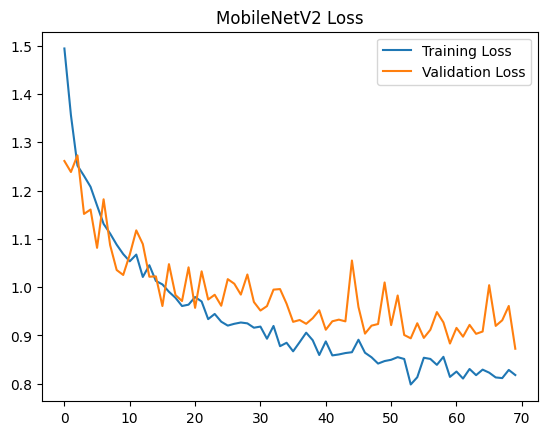

In [106]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.title("MobileNetV2 Loss")
plt.legend()
plt.show()

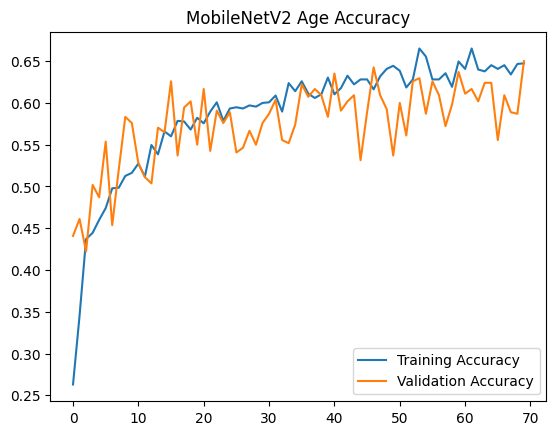

In [107]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.title("MobileNetV2 Age Accuracy")
plt.legend()
plt.show()

In [108]:
test_loss, test_acc = model.evaluate(age_test_ds)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - acc: 0.6238 - loss: 0.8970
Test accuracy: 0.637
Test loss: 0.878


In [109]:
age_lossacc = pd.DataFrame(history.history)
age_lossacc.to_csv("age_lossacc.csv")

## Handedness Target Var. Attempt

In [110]:
hand_df = gender_df[['wid','hand']].copy()

hand_df.head()

,wid,hand
0,35,right
1,62,right
2,94,right
3,30,right
4,70,right


In [112]:
hand_df['hand'].value_counts()

,count
hand,
right,79
left,10
ambidextrous,1


removing ambidexterity for simplicity

In [113]:
shutil.rmtree("/content/Data")
reload_data.full_unzip_and_stratify("/content/CSAFE_Handwriting_Images.zip","/content/Data")

Found 1350 files belonging to 90 classes.
Found 540 files belonging to 90 classes.
Found 540 files belonging to 90 classes.


(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 384, 384, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>)

In [115]:
for current_dir in ["/content/Data/val","/content/Data/train","/content/Data/test"]:
    os.mkdir(f"{current_dir}/right")
    right_dir = f"{current_dir}/right"
    os.mkdir(f"{current_dir}/left")
    left_dir = f"{current_dir}/left"

    for w_folder in list(os.listdir(current_dir)): #w_folders = writer ids
        if w_folder in ["right", "left"]:  # skip your new folders
            continue

        id = int(w_folder[2:])
        cat = hand_df.loc[hand_df["wid"] == id, "hand"].iloc[0]

        if cat == "right":
            # Move the entire folder 'source_folder' into 'destination_folder'
            shutil.move(f"{current_dir}/{w_folder}", right_dir)
        elif cat == "left":
            shutil.move(f"{current_dir}/{w_folder}", left_dir)
        elif cat == "ambidextrous":
            shutil.rmtree(f"{current_dir}/{w_folder}")
        else:
            print(f"SKIPPED: {w_id} --> {cat}")

In [ ]:
source_dir

'/content/Data'

In [114]:
IMAGE_SIZE=(256,256)
BATCH_SIZE = 32

In [117]:
hand_df = hand_df[hand_df['hand']!="ambidextrous"]

,,count
wid,hand,
1,right,1
2,right,1
3,right,1
5,right,1
6,right,1
...,...,...
152,right,1
153,right,1
154,right,1


In [118]:
hand_df['hand'].value_counts()

,count
hand,
right,79
left,10


In [119]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=hand_df["hand"].unique(),
    y=hand_df["hand"]
)

class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: np.float64(0.5632911392405063), 1: np.float64(4.45)}


In [120]:
hand_train_ds,hand_val_ds,hand_test_ds = reload_data.train_val_test_split(
    source_dir,IMAGE_SIZE,BATCH_SIZE=BATCH_SIZE
)

Found 1335 files belonging to 2 classes.
Found 534 files belonging to 2 classes.
Found 534 files belonging to 2 classes.


In [122]:
hand_model = keras.applications.MobileNetV2(
                        include_top = False,
                        #classifier_activation="softmax",
                        weights = "imagenet",
                        input_shape=(IMAGE_SIZE + (3,))
                        )

/tmp/ipython-input-3379548504.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  hand_model = keras.applications.MobileNetV2(


In [123]:
def make_transfer_model(input_shape, num_classes):
    backbone = hand_model
    backbone.trainable = False

    inputs = layers.Input(input_shape)
    x = keras.applications.mobilenet_v2.preprocess_input(inputs) #changed to mobilenetv2
    x = backbone(x)
    x = layers.Dropout(0.3)(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.25)(x) #changed to 30% dropout

    outputs = layers.Dense(1, activation=None)(x) #change to binary (1 neuron)

    return keras.Model(inputs, outputs, name="mobilenet_hand")

INPUT_SHAPE = (256,256,3)
model = make_transfer_model(input_shape=INPUT_SHAPE, num_classes=2)

In [124]:
hand_train_ds = hand_train_ds.prefetch(tf_data.AUTOTUNE)
hand_val_ds = hand_val_ds.prefetch(tf_data.AUTOTUNE)

In [126]:
%%time

epochs = 70

#callbacks = [keras.callbacks.ModelCheckpoint("save_at_epoch{epoch}.keras"),]

model.compile(
    optimizer= "adam",
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=[keras.metrics.BinaryAccuracy(name="acc")],
    )

history = model.fit(
    hand_train_ds,
    epochs = epochs,
    #callbacks= callbacks,
    class_weight=class_weights,
    validation_data = hand_val_ds)

model.save("MobileNetV2_hand.keras")

Epoch 1/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 55s 1s/step - acc: 0.6933 - loss: 1.3537 - val_acc: 0.8876 - val_loss: 0.5894
Epoch 2/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - acc: 0.8998 - loss: 0.3180 - val_acc: 0.8876 - val_loss: 0.5210
Epoch 3/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 0.8902 - loss: 0.3361 - val_acc: 0.8876 - val_loss: 0.4907
Epoch 4/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - acc: 0.8991 - loss: 0.3045 - val_acc: 0.8876 - val_loss: 0.4897
Epoch 5/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 139ms/step - acc: 0.8995 - loss: 0.3096 - val_acc: 0.8876 - val_loss: 0.4794
Epoch 6/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - acc: 0.8964 - loss: 0.3100 - val_acc: 0.8876 - val_loss: 0.4830
Epoch 7/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc: 0.8892 - loss: 0.3281 - val_acc: 0.8876 - val_loss: 0.4909
Epoch 8/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - acc: 0.8933 - loss: 0.3157 - val_acc: 0.8876 - val_loss: 0.4769
Epoch 9/70
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 138ms/step - acc:

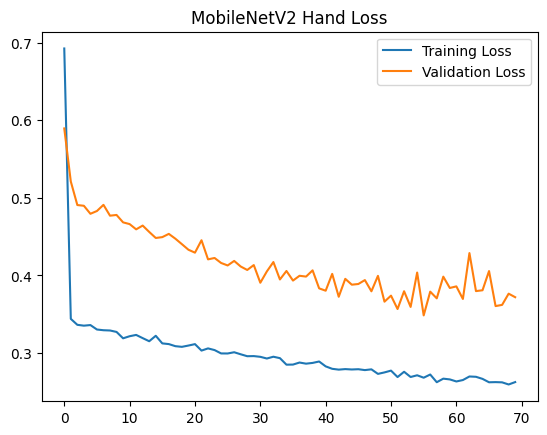

In [127]:
plt.plot(range(len(history.history["loss"])),history.history["loss"],label="Training Loss")
plt.plot(range(len(history.history["val_loss"])),history.history["val_loss"],label="Validation Loss")
plt.title("MobileNetV2 Hand Loss")
plt.legend()
plt.show()

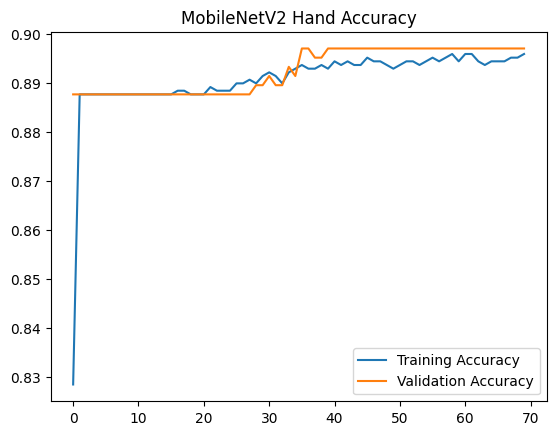

In [128]:
plt.plot(range(len(history.history["acc"])),history.history["acc"],label="Training Accuracy")
plt.plot(range(len(history.history["val_acc"])),history.history["val_acc"],label="Validation Accuracy")
plt.title("MobileNetV2 Hand Accuracy")
plt.legend()
plt.show()

In [129]:
test_loss, test_acc = model.evaluate(hand_test_ds)
print(f"Test accuracy: {test_acc:.3f}")
print(f"Test loss: {test_loss:.3f}")

17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - acc: 0.9086 - loss: 0.3172
Test accuracy: 0.891
Test loss: 0.373


In [130]:
hand_lossacc = pd.DataFrame(history.history)
hand_lossacc.to_csv("hand_lossacc.csv")

not significant, only as good as majority class

In [131]:
79/89

0.8876404494382022